In [137]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.close('all')

In [138]:
# which algorithm to use? Choose between 'NaiveBayes' or 'SVM'
algo = 'SVM'

In [139]:
# load in Jones data (this is my training/test data)
df = pd.read_pickle('output/features_svm')

# load in Gruendl data (I will use this later on the fully trained model, to see how well it works on distinguishing contaminants)
df2 = pd.read_pickle('output/features_svm_gruendl_testdata')

In [140]:
# for simplicity, we shall consider the binary classification 'YSO' versus 'non-YSO'.
# I label all subgroups 'YSO1', 'YSO2', 'YSO3', 'YSO4', 'HII', and 'HII/YSO3' sources as 'YSO'
# all other objects (background galaxies, AGB stars, PNe, etc.) will fall in the 'non-YSO' class.
df['class'] = 'non-YSO'
df['class'][df['SpClass'] == 'YSO1'] = 'YSO'
df['class'][df['SpClass'] == 'YSO2'] = 'YSO'
df['class'][df['SpClass'] == 'YSO3'] = 'YSO'
df['class'][df['SpClass'] == 'YSO4'] = 'YSO'
df['class'][df['SpClass'] == 'HII'] = 'YSO'
df['class'][df['SpClass'] == 'HII/YSO3'] = 'YSO'

In [141]:
# create  data
X = df[['[8.0]','[4.5-8.0]','[8.0-24]','sigmadust']]
y = df['class']

In [142]:
# I will use the Gruendl's data to test the trained model in the end. This list is separated in YSO and non-YSO list (background galaxies, AGB stars, PNe). The YSO list has shown to be ~99% accurate (Jones et al. 2017).
X2_test = df2[['[8.0]','[4.5-8.0]','[8.0-24]','sigmadust']]
y2_test = df2['class']

In [143]:
####################################
# TRAINING THE MODEL
####################################

# import modules
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, train_test_split, learning_curve 
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sys import exit

In [144]:
# initiate model and grid parameters
if algo == 'NaiveBayes':
    est = GaussianNB()
    grid_pars = {}

elif algo == 'SVM':
    est = SVC(kernel='rbf')
    hparam = np.logspace(-0.5,0.5, 10)
    grid_pars = {'svc__C': hparam}
                   
model = make_pipeline(est)

In [145]:
# do a 10 K-fold with stratification to ensure a balanced training/test set. Also repeat to push down variance in CV results
cv = RepeatedStratifiedKFold(n_splits=10,n_repeats=20)

In [146]:
# Split the dataset in 70%/30% parts (train/test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

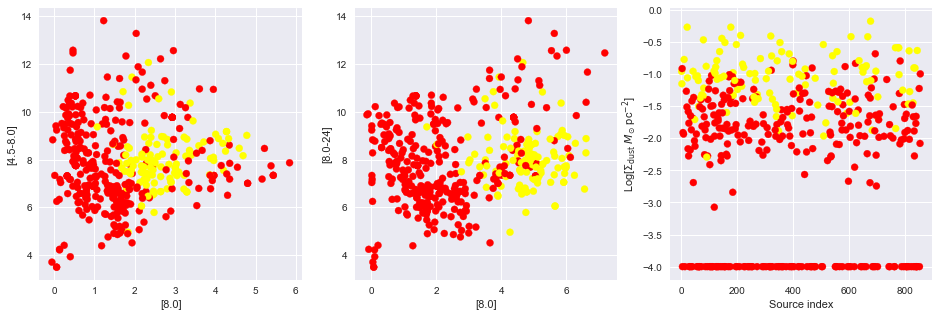

In [147]:
# Visualize the data
# first make color series to distinguish classes
import vis_data

col = np.copy(y_train)
col[y_train == 'non-YSO'] = 'red'
col[y_train == 'YSO'] = 'yellow'
fig = vis_data.visdata(X_train.index,X_train['[8.0]'],X_train['[4.5-8.0]'],X_train['[8.0-24]'],X_train['sigmadust'],col,'train_test')
plt.show()

In [148]:
# Do the grid search; make sure optimal parameters do not fall on edge of the grid
grid = GridSearchCV(model, grid_pars, cv=cv)
grid.fit(X_train, y_train)

print grid.best_params_

{'svc__C': 0.68129206905796125}


In [149]:
# save the grid of searched hyperparameters, and the mean + std of the K-fold cross validations to plot later
# means = grid.cv_results_['mean_test_score']
# stds = grid.cv_results_['std_test_score']
# results = pd.DataFrame({"hparam": C_range,"mean": means,"std":stds})

In [150]:
# test the model with the test data the model hasn't seen
# print classification report -> LOOKS GREAT (~94% accuracy)
model = grid.best_estimator_
y_test_fit = model.predict(X_test)

# print classification report
print '============ Classification report using '+algo+' ============'
print classification_report(y_test, y_test_fit)

============ Classification report using SVM ============
             precision    recall  f1-score   support

        YSO       0.85      0.92      0.88        50
    non-YSO       0.97      0.94      0.95       132

avg / total       0.94      0.93      0.93       182



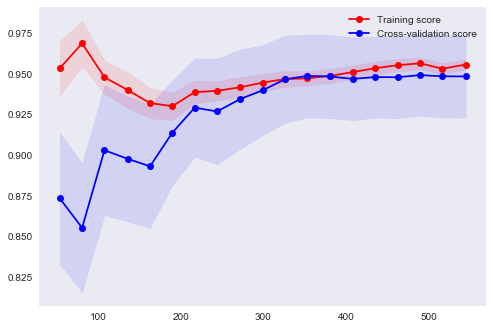

In [151]:
# Some other diagnostics:

# first the learning curve + 1 sigma Conf band of my optimized model 
# Note #1: training curve is increasing slightly: noise in the data?
# Note #2: the cross-validation curve has pretty high variance --> perhaps an imbalance between training/test sets. Will look into this.
# Other wise, the learning curve looks good (no obvious bias / variance). CV result reaches an asymptotic value, so adding training data may not work. 
train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=cv, n_jobs=10, train_sizes=np.linspace(.1, 1.0, 19))
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.close('all')
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
            train_scores_mean + train_scores_std, alpha=0.1,
            color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
            test_scores_mean + test_scores_std, alpha=0.1, color="b")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
     label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="b",
     label="Cross-validation score")

plt.legend(loc="best")
plt.show()
plt.savefig('output/learning_curve_'+algo+'.pdf', dpi=150, bbox_inches='tight', pad_inches=0.2)

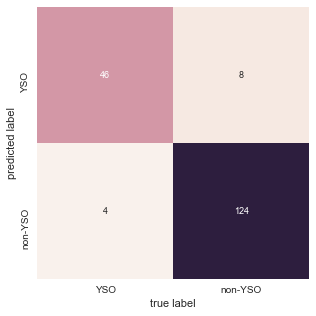

In [152]:
# plot confusion matrix to get a better sense of what has been classified.
# to add: ROC diagnostics
conf_mat = confusion_matrix(y_test,y_test_fit)

fig = plt.figure(figsize=(5,5))
font = {'size':9}
plt.rc('font', **font)

sns.heatmap(conf_mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['YSO','non-YSO'],
            yticklabels=['YSO','non-YSO'])

plt.xlabel('true label')
plt.ylabel('predicted label');
plt.savefig('output/confusion_matrix.pdf', dpi=150, bbox_inches='tight', pad_inches=0.2)
plt.show()

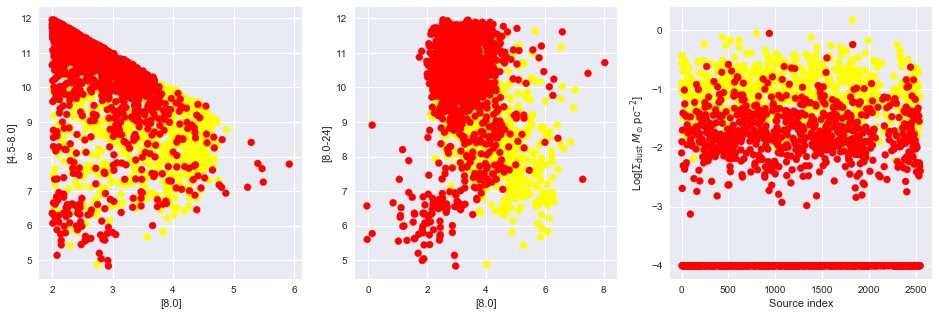

In [154]:
# now for a serious another test; the Gruendl data...which is complex, as it ONLY contains sources within the YSO color space, but contains all contaminants. 
# visualize it:
col2 = np.copy(y2_test)
col2[y2_test == 'non-YSO'] = 'red'
col2[y2_test == 'YSO'] = 'yellow'
fig = vis_data.visdata(y2_test.index,X2_test['[8.0]'],X2_test['[4.5-8.0]'],X2_test['[8.0-24]'],X2_test['sigmadust'],col2,'gruendl')
plt.show()

In [155]:
# How well does the model separate out the YSOs in the confused color space? We expect it to be lower than the training/test score.
y2_fit = model.predict(X2_test)

print '======Classification report on unseen, complex data========'
print classification_report(y2_test, y2_fit)
print '==========================================================='

======Classification report on unseen, complex data========
             precision    recall  f1-score   support

        YSO       0.92      0.65      0.76       705
    non-YSO       0.83      0.97      0.90      1270

avg / total       0.86      0.86      0.85      1975



In [156]:
# The model has a 0.85 precision and recall on data that is overlapping in color-color and color-magnitude space!
# This means the additional feature (the dust surface density) is very powerful in separating the classes.